In [1]:
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.WARN)
import ray
ray.init(log_to_driver=False)
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.random_circuit import random_circuits
from janusq.data_objects.backend import FullyConnectedBackend

from janusq.simulator.noisy_simulator import NoisySimulator
import random

from janusq.tools.ray_func import map

2024-04-16 10:54:50,472	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67072000 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-04-16 10:54:50,618	INFO worker.py:1724 -- Started a local Ray instance.


# Noise Optimization Based on JanusQ-CT


**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

The accurate fidelity prediction enables JanusQ-CT to guide the noise optimization. In this notebook, we introduce two optimization strategies.

## Mapping

A typical compilation flow includes routing and scheduling. The routing pass transforms the circuit to satisfy the processor topology. Clearly, it inserts SWAP gates to change the qubit mapping, ensuring that all two-qubit gates can be implemented by the coupler of the processor. By precisely predicting the fidelity, QuCT can be integrated with existing compilers to find the routing solution with the best fidelity. 

For example, wecan use Janus-CT to guide the mapping of qiskit.

In [4]:
# build a simulator

n_qubits = 5
n_steps = 1
n_walks = 20
backend = FullyConnectedBackend(n_qubits)

circuits = random_circuits(backend, n_circuits=300, n_gate_list=[30, 50, 100], two_qubit_prob_list=[.4], reverse=True)
vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
vec_model.train(circuits, multi_process=False, remove_redundancy = False)

all_paths = vec_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = vec_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

100%|██████████| 300/300 [00:02<00:00, 106.87it/s]


In [5]:
# train a fidelity model
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=True)

fidelity_model = FidelityModel(vec_model)
fidelity_model.train((circuits, ground_truth_fidelities))

240it [00:00, 660520.31it/s]
60it [00:00, 390167.81it/s]


In [7]:
# generate a set of benchmarking circuits

from janusq.data_objects.algorithms import get_algorithm_circuits
from janusq.optimizations.scheduling.scheduling_ct import Scheduler
from janusq.optimizations.mapping.mapping_ct import Mapper
algs = ['qft', 'hs', 'ghz']
benchmarking_circuits = get_algorithm_circuits(n_qubits, backend, algs)

We evaluate the mapping guided by JanusQ-CT model with the qiskit optimizer with level = 3.

In [8]:
from janusq.data_objects.backend import LinearBackend


mapper = Mapper(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = mapper.run(circuit, mapping_backend, return_candidates=False)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before mapping: ', baseline_fidelities[-1], 'after mapping: ', opt_fidelities[-1])

before mapping:  0.8198721319975162 after mapping:  0.8167956914878906
before mapping:  0.5334649937684823 after mapping:  0.30885473973704175
before mapping:  0.08252876099213952 after mapping:  0.05392402505539664


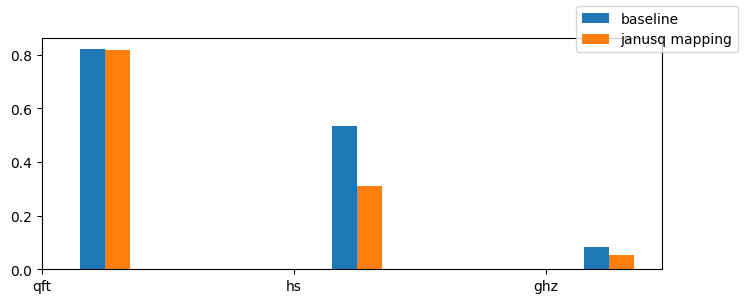

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(8, 3))  
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq mapping')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()

## Scheduling

We can also use Janus-CT to guide the scheduling.

In [10]:
scheduler = Scheduler(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = scheduler.run(circuit, timeout=60)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before scheduling: ', baseline_fidelities[-1], 'after scheduling: ', opt_fidelities[-1])

before scheduling:  0.8693056512426821 after scheduling:  0.7263926331246036
before scheduling:  0.5268674466647589 after scheduling:  0.5230549604815411
before scheduling:  0.051013266957493295 after scheduling:  0.07418125361532334


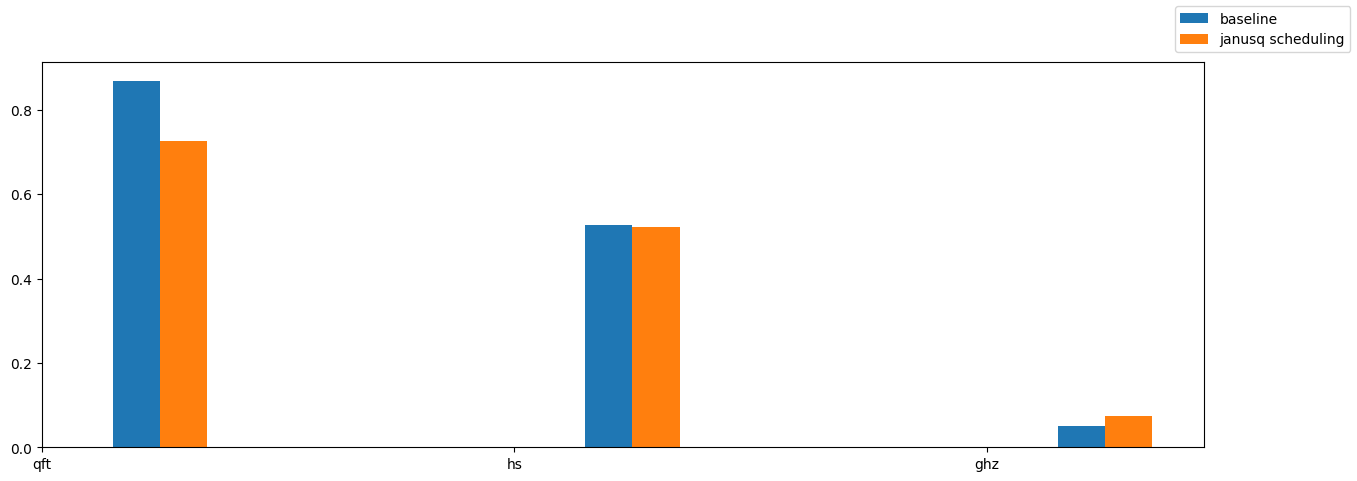

In [11]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq scheduling')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()